In [11]:
import os, sys

# Notebook lives in <project>/notebooks/, so add its parent (the project root)
proj_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, proj_root)

print("Project root added to sys.path:", proj_root)

Project root added to sys.path: /Users/varunjhaveri/Desktop/Spring 25/MATH 590/loss-landscape


In [12]:
import torch.optim as optim

from models.shallow_relu import ShallowReLU
from experiments.shallow_trainer import ShallowReLUTrainer
from experiments.loss_surface_visualizer import LossSurfaceVisualizer
from analysis.gradient_analysis import GradientAnalyzer
from data.synthetic_generator import SyntheticDatasetBuilder
from experiments.activation_pattern_visualizer import ActivationPatternVisualizer
from experiments.critical_point_classifier import CriticalPointClassifier
from experiments.gradient_trajectory_analyzer import GradientTrajectoryAnalyzer
from experiments.weight_norm_monitor import WeightNormMonitor

In [13]:
# blobs, circles, or moons
builder = SyntheticDatasetBuilder(dataset_type="moons",
                                  n_samples=300,
                                  noise=0.1,
                                  test_size=0.2,
                                  random_state=42)
X_train, X_test, y_train, y_test = builder.generate()

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape, y_test.shape)


Train shapes: torch.Size([240, 2]) torch.Size([240, 1])
Test  shapes: torch.Size([60, 2]) torch.Size([60, 1])


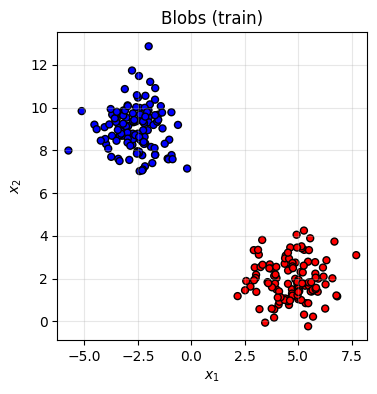

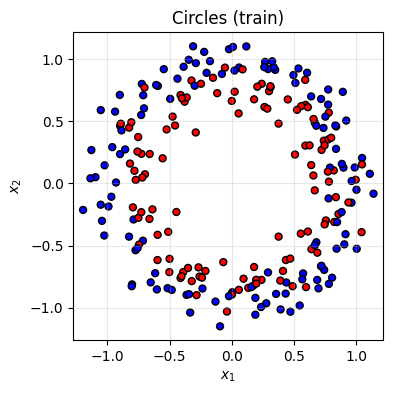

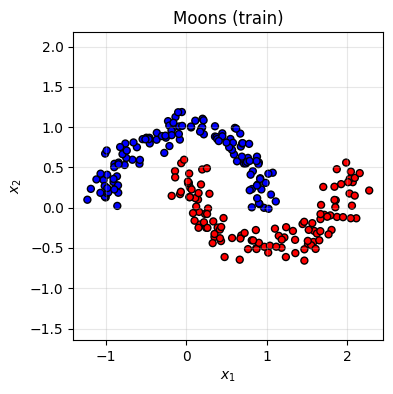

In [14]:
import matplotlib.pyplot as plt

def plot_dataset(X, y, title):
    X_np = X.numpy()
    y_np = y.squeeze().numpy()
    plt.scatter(X_np[:, 0], X_np[:, 1],
                c=y_np, cmap="bwr", edgecolors="k", s=25)
    plt.title(title)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.grid(alpha=0.3)
    plt.axis("equal")
    plt.show()         

for dtype in ["blobs", "circles", "moons"]:
    builder = SyntheticDatasetBuilder(dataset_type=dtype,
                                      n_samples=300,
                                      noise=0.10,
                                      test_size=0.2,
                                      random_state=42)
    X_tr, _, y_tr, _ = builder.generate()

    plt.figure(figsize=(4, 4))   
    plot_dataset(X_tr, y_tr, f"{dtype.capitalize()} (train)")


Epoch  10: Loss = 0.7185
Epoch  20: Loss = 0.7116
Epoch  30: Loss = 0.7051
Epoch  40: Loss = 0.6991
Epoch  50: Loss = 0.6934
Epoch  60: Loss = 0.6881
Epoch  70: Loss = 0.6830
Epoch  80: Loss = 0.6782
Epoch  90: Loss = 0.6735
Epoch 100: Loss = 0.6690
Epoch 110: Loss = 0.6647
Epoch 120: Loss = 0.6604
Epoch 130: Loss = 0.6563
Epoch 140: Loss = 0.6523
Epoch 150: Loss = 0.6484
Epoch 160: Loss = 0.6445
Epoch 170: Loss = 0.6407
Epoch 180: Loss = 0.6369
Epoch 190: Loss = 0.6332
Epoch 200: Loss = 0.6295
Epoch 210: Loss = 0.6258
Epoch 220: Loss = 0.6222
Epoch 230: Loss = 0.6186
Epoch 240: Loss = 0.6150
Epoch 250: Loss = 0.6114
Epoch 260: Loss = 0.6078
Epoch 270: Loss = 0.6042
Epoch 280: Loss = 0.6007
Epoch 290: Loss = 0.5972
Epoch 300: Loss = 0.5936
Epoch 310: Loss = 0.5901
Epoch 320: Loss = 0.5866
Epoch 330: Loss = 0.5831
Epoch 340: Loss = 0.5796
Epoch 350: Loss = 0.5761
Epoch 360: Loss = 0.5726
Epoch 370: Loss = 0.5691
Epoch 380: Loss = 0.5657
Epoch 390: Loss = 0.5622
Epoch 400: Loss = 0.5588


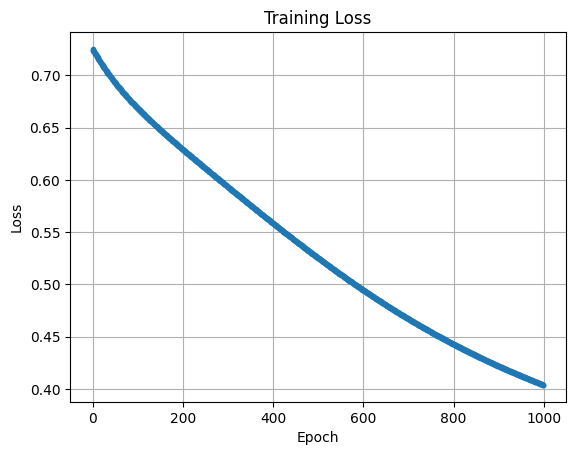

Test Accuracy: 88.33%


0.8833333253860474

In [15]:
trainer = ShallowReLUTrainer(input_dim=2,   
                             hidden_dim=5,  
                             lr=0.01,
                             num_epochs=1000)

# override with the generated data
trainer.X_train, trainer.X_test = X_train, X_test
trainer.y_train, trainer.y_test = y_train, y_test

trainer.train()
trainer.plot_loss_curve()
trainer.evaluate()

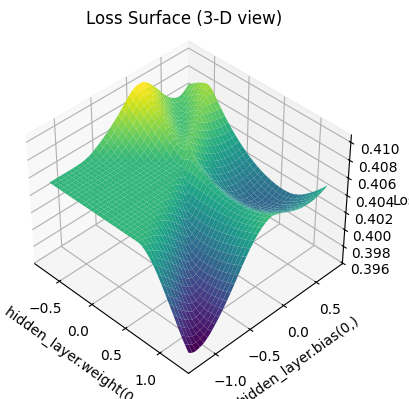

In [16]:
vis = LossSurfaceVisualizer(
    trainer.model,
    trainer.criterion,
    trainer.X_train,
    trainer.y_train
)

# # Sweep around the first hidden weight & bias:
# vis.sweep_2d(
#     param1=('hidden_layer.weight', (0, 0)),
#     param2=('hidden_layer.bias',   (0,)),
#     resolution=50,
#     span=1.0
# )
# vis.plot_surface()
#vis = LossSurfaceVisualizer(model, criterion, X_train, y_train)
vis.sweep_2d(param1=('hidden_layer.weight', (0, 0)),
             param2=('hidden_layer.bias',   (0,)),
             resolution=75, span=1.0)
vis.plot_surface3d(elev=40, azim=-45)


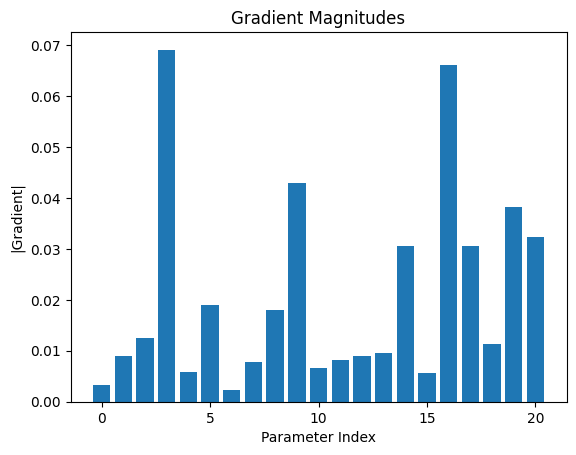

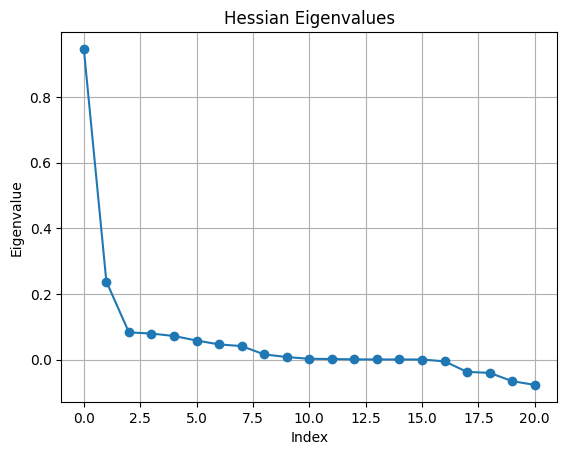

In [19]:
analyzer = GradientAnalyzer(
    trainer.model,
    trainer.criterion,
    trainer.X_train,
    trainer.y_train
)

# Gradient magnitudes
analyzer.plot_gradient_norm()

H = analyzer.compute_hessian()
analyzer.plot_hessian_spectrum(H)


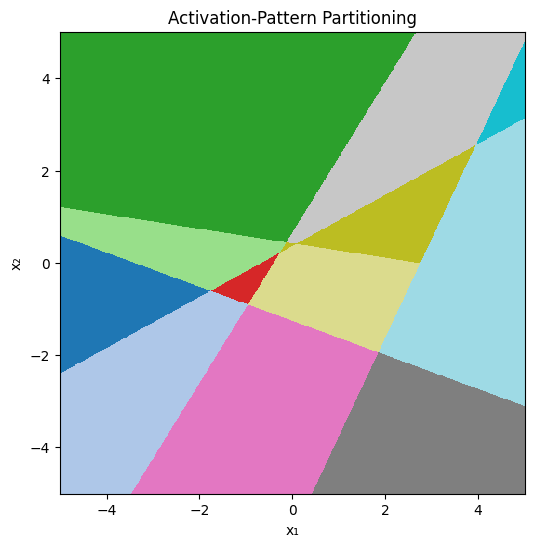

In [21]:
# Instantiating the visualizer
partitioner = ActivationPatternVisualizer(
    trainer.model,
    xlim=(-5, 5),       # should cover data range
    ylim=(-5, 5),
    resolution=500      # finer grid for the smoother regions
)

# Computing activation patterns over the grid
partitioner.compute_patterns()
partitioner.plot_partition()


In [22]:
# Critical Point Classification

cpc = CriticalPointClassifier(
    trainer.model,
    trainer.criterion,
    trainer.X_train,
    trainer.y_train
)
label, eigs = cpc.classify_current(
    grad_tol=1e-2,  
    eig_tol=1e-4    
)
print("This point is classified as:", label)


This point is classified as: Not critical (‖∇L‖ > tol)


Epoch  10: Loss=0.3125, ‖∇L‖=0.0798
Epoch  20: Loss=0.3067, ‖∇L‖=0.0712
Epoch  30: Loss=0.3019, ‖∇L‖=0.0668
Epoch  40: Loss=0.2979, ‖∇L‖=0.0604
Epoch  50: Loss=0.2945, ‖∇L‖=0.0555
Epoch  60: Loss=0.2916, ‖∇L‖=0.0513
Epoch  70: Loss=0.2892, ‖∇L‖=0.0477
Epoch  80: Loss=0.2871, ‖∇L‖=0.0440
Epoch  90: Loss=0.2853, ‖∇L‖=0.0408
Epoch 100: Loss=0.2837, ‖∇L‖=0.0380


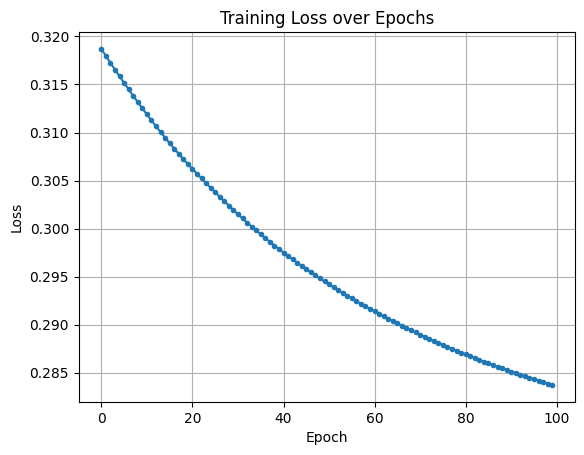

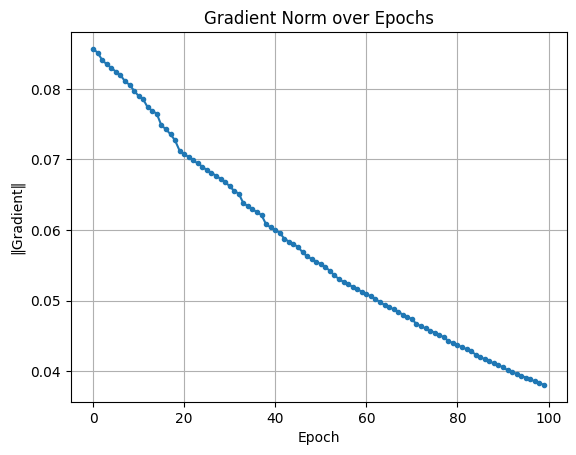

In [25]:
# instantiate optimizer
optimizer = optim.SGD(trainer.model.parameters(), lr=0.1)

# run tracking
gt_analyzer = GradientTrajectoryAnalyzer(
    trainer.model,
    trainer.criterion,
    optimizer,
    trainer.X_train,
    trainer.y_train,
    num_epochs=100
)
loss_hist, grad_norms = gt_analyzer.track()

# plots
gt_analyzer.plot_loss()
gt_analyzer.plot_grad_norm()


Epoch  10: Loss = 0.7667
Epoch  20: Loss = 0.7502
Epoch  30: Loss = 0.7379
Epoch  40: Loss = 0.7282
Epoch  50: Loss = 0.7205
Epoch  60: Loss = 0.7145
Epoch  70: Loss = 0.7098
Epoch  80: Loss = 0.7061
Epoch  90: Loss = 0.7032
Epoch 100: Loss = 0.7009
Test Accuracy: 55.00%
Epoch  10: Loss = 0.4708
Epoch  20: Loss = 0.4100
Epoch  30: Loss = 0.3693
Epoch  40: Loss = 0.3367
Epoch  50: Loss = 0.3090
Epoch  60: Loss = 0.2849
Epoch  70: Loss = 0.2636
Epoch  80: Loss = 0.2446
Epoch  90: Loss = 0.2277
Epoch 100: Loss = 0.2126
Test Accuracy: 100.00%
Epoch  10: Loss = 0.6884
Epoch  20: Loss = 0.6699
Epoch  30: Loss = 0.6340
Epoch  40: Loss = 0.5682
Epoch  50: Loss = 0.4903
Epoch  60: Loss = 0.4256
Epoch  70: Loss = 0.3772
Epoch  80: Loss = 0.3398
Epoch  90: Loss = 0.3096
Epoch 100: Loss = 0.2842
Test Accuracy: 100.00%
Epoch  10: Loss = 0.1801
Epoch  20: Loss = 0.0835
Epoch  30: Loss = 0.0505
Epoch  40: Loss = 0.0351
Epoch  50: Loss = 0.0265
Epoch  60: Loss = 0.0211
Epoch  70: Loss = 0.0175
Epoch  

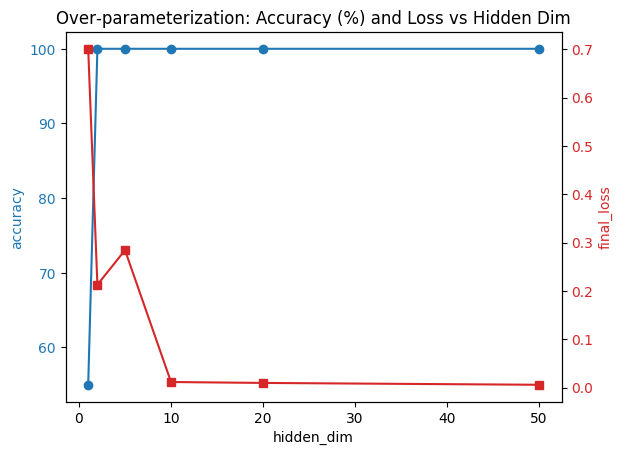

In [26]:
# Over‑parameterization Study
import matplotlib.pyplot as plt
from data.synthetic_generator import SyntheticDatasetBuilder
from experiments.overparam_experiment import OverparamExperiment

# 1) Prepare dataset builder
builder = SyntheticDatasetBuilder(dataset_type="blobs", n_samples=500, noise=0.1)

# 2) Define hidden dims to sweep
hidden_sizes = [1, 2, 5, 10, 20, 50]

# 3) Run the experiment
exp = OverparamExperiment(builder, hidden_dims=hidden_sizes, lr=0.05, num_epochs=100)
df = exp.run()
print(df)

# 4) Plot results
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('hidden_dim')
ax1.set_ylabel('accuracy', color=color)
ax1.plot(df.hidden_dim, df.accuracy * 100, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('final_loss', color=color)
ax2.plot(df.hidden_dim, df.final_loss, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Over‑parameterization: Accuracy (%) and Loss vs Hidden Dim")
plt.show()


Epoch  10: Loss=0.4183, WeightNorm=2.6644
Epoch  20: Loss=0.4030, WeightNorm=2.7575
Epoch  30: Loss=0.3888, WeightNorm=2.8485
Epoch  40: Loss=0.3759, WeightNorm=2.9371
Epoch  50: Loss=0.3642, WeightNorm=3.0231
Epoch  60: Loss=0.3537, WeightNorm=3.1060
Epoch  70: Loss=0.3442, WeightNorm=3.1856
Epoch  80: Loss=0.3358, WeightNorm=3.2616
Epoch  90: Loss=0.3284, WeightNorm=3.3339
Epoch 100: Loss=0.3218, WeightNorm=3.4025


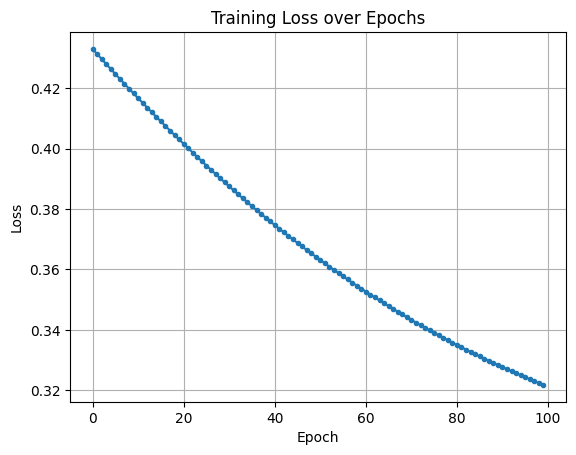

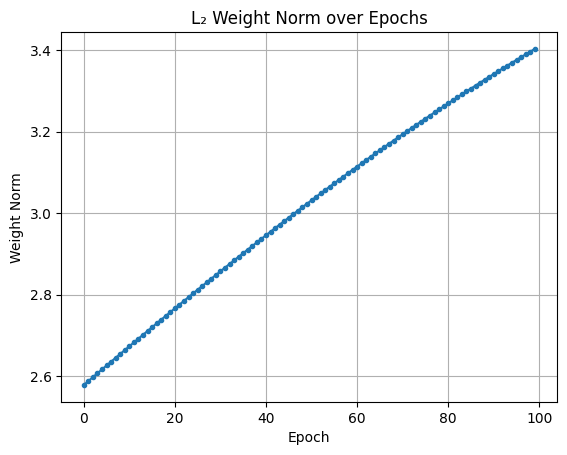

In [11]:
# Implicit Regularization via Weight Norm

# 1) set up optimizer
optimizer = optim.SGD(trainer.model.parameters(), lr=0.1)

# 2) track weight norms
wn_monitor = WeightNormMonitor(
    trainer.model,
    trainer.criterion,
    optimizer,
    trainer.X_train,
    trainer.y_train,
    num_epochs=100
)
loss_hist, wnorms = wn_monitor.track()

# 3) plot
wn_monitor.plot_loss()
wn_monitor.plot_weight_norm()


In [15]:
loss_hist, grad_norms = gt_analyzer.track()
for epoch, gn in enumerate(grad_norms, start=1):
    if gn < 1e-3:  # your stationary threshold
        label, _ = cpc.classify_current()
        print(f"Epoch {epoch:3d}: grad_norm={gn:.4e}, classified as {label}")
        break

Epoch  10: Loss=0.2838, ‖∇L‖=0.0407
Epoch  20: Loss=0.2822, ‖∇L‖=0.0386
Epoch  30: Loss=0.2808, ‖∇L‖=0.0368
Epoch  40: Loss=0.2795, ‖∇L‖=0.0349
Epoch  50: Loss=0.2783, ‖∇L‖=0.0335
Epoch  60: Loss=0.2772, ‖∇L‖=0.0322
Epoch  70: Loss=0.2762, ‖∇L‖=0.0310
Epoch  80: Loss=0.2753, ‖∇L‖=0.0299
Epoch  90: Loss=0.2744, ‖∇L‖=0.0288
Epoch 100: Loss=0.2736, ‖∇L‖=0.0280
